# Model Comparison

In [53]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [8]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TreasuryInflationPCA\root\src")
sys.path.append(r"/Users/diegoalvarez/Desktop/research/TreasuryInflationPCA/root/src")
from BackgroundFuncs import BackgroundHelperFuncs

df_log_pc = BackgroundHelperFuncs().get_log_pca()
df_nom_pc = BackgroundHelperFuncs().get_pca()

## Comparing Signals

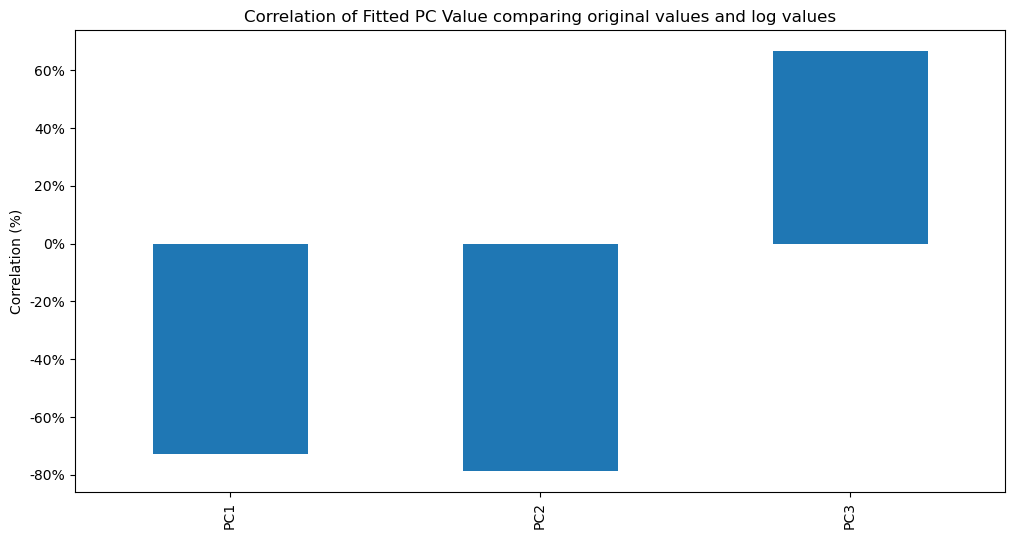

In [61]:
def plot_signal_correlation(df_log_pc: pd.DataFrame, df_nom_pc: pd.DataFrame) -> plt.Figure: 

    df_log_tmp = (df_log_pc[
        ["date", "variable", "spread"]].
        rename(columns = {"spread": "log_spread"}))
    
    df_nom_tmp = (df_nom_pc[
        ["date", "variable", "spread"]].
        rename(columns = {"spread": "nom_spread"}))
    
    fig, axes = plt.subplots(figsize = (12,6))
    
    (df_log_tmp.merge(
        right = df_nom_tmp, how = "inner", on = ["date", "variable"]).
        drop(columns = ["date"]).
        groupby("variable").
        agg("corr").
        reset_index().
        query("log_spread != 1").
        set_index("variable")
        [["log_spread"]].
        plot(
            ax     = axes,
            legend = False,
            kind   = "bar",
            xlabel = "",
            ylabel = "Correlation (%)",
            title  = "Correlation of Fitted PC Value comparing original values and log values"))
    
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))

plot_signal_correlation(df_log_pc, df_nom_pc)

In [90]:
def combine_backtest(df_nom_pc: pd.DataFrame, df_log_pc: pd.DataFrame) -> pd.DataFrame: 

    df_nom_backtest = BackgroundHelperFuncs().get_backtest(df_nom_pc)
    df_log_backtest = BackgroundHelperFuncs().get_log_backtest(df_log_pc)
    
    df_log_tmp = (df_log_backtest[
        ["date", "variable", "security", "signal_bps"]].
        rename(columns = {"signal_bps": "log_bps"}))
    
    df_nom_tmp = (df_nom_backtest[
        ["date", "variable", "security", "signal_bps"]].
        rename(columns = {"signal_bps": "nom_bps"}))
    
    df_combined = (df_log_tmp.merge(
        right = df_nom_tmp, how = "inner", on = ["date", "variable", "security"]))

    return df_combined

df_combined = combine_backtest(df_nom_pc, df_log_pc)

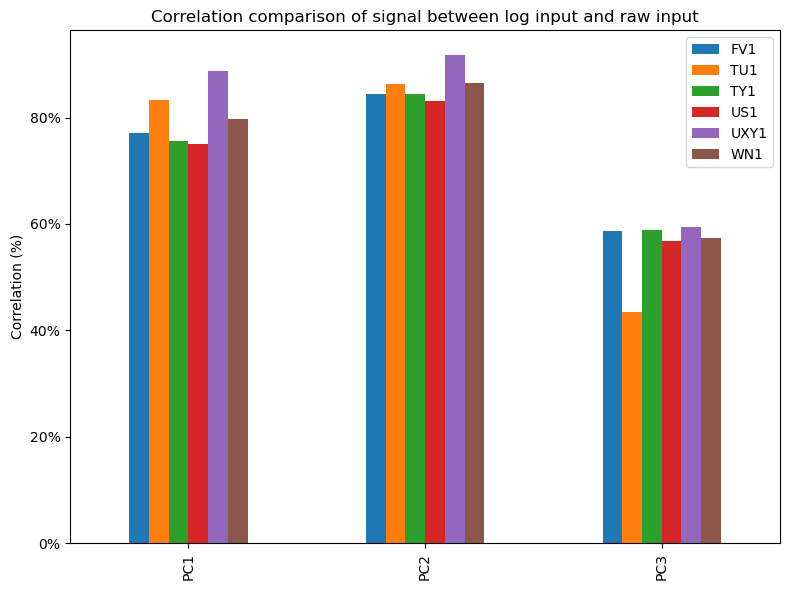

In [131]:
def plot_signal_comparison_correlation(df_combined: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(figsize = (8,6))
    
    (df_combined.drop(
        columns = ["date"]).
        groupby(["variable", "security"]).
        agg("corr").
        query("log_bps != 1").
        reset_index().
        drop(columns = ["level_2", "nom_bps"]).
        assign(security = lambda x: x.security.str.split(" ").str[0]).
        rename(columns = {"security": ""}).
        pivot(index = "variable", columns = "", values = "log_bps").
        plot(
            kind   = "bar",
            ax     = axes,
            ylabel = "Correlation (%)",
            xlabel = "",
            title  = "Correlation comparison of signal between log input and raw input"))

    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    plt.tight_layout()

plot_signal_comparison_correlation(df_combined)

## Comparing Cross Correlation

In [152]:
def get_avg_cross_correlation(df: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df.reset_index().rename(
        columns = {"variable": "var1"}).
        melt(id_vars = "var1").
        query("variable != var1").
        assign(
            end1 = lambda x: x.var1.str.split(" ").str[-1],
            end2 = lambda x: x.variable.str.split(" ").str[-1]).
        query("end1 == end2").
        groupby("end1").
        head(1)
        [["end1", "value"]].
        rename(columns = {"end1": "PC"}).
        set_index("PC"))

    return df_out

In [168]:
def get_cross_correlation_comparison(df_log_pc: pd.DataFrame, df_nom_pc: pd.DataFrame) -> pd.DataFrame: 

    df_log_corr = BackgroundHelperFuncs().get_correlation(df_log_pc)
    df_nom_corr = BackgroundHelperFuncs().get_correlation(df_nom_pc)
    
    df_left = (get_avg_cross_correlation(
        df = df_log_corr).
        rename(columns = {"value": "Using Log Input"}))
    
    df_right = (get_avg_cross_correlation(
        df = df_nom_corr).
        rename(columns = {"value": "Using None"}))
    
    df_combined = (df_left.merge(
        right = df_right, how = "inner", on = ["PC"]))

    return df_combined

df_cross_correlation_comparison = get_cross_correlation_comparison(df_log_pc, df_nom_pc)

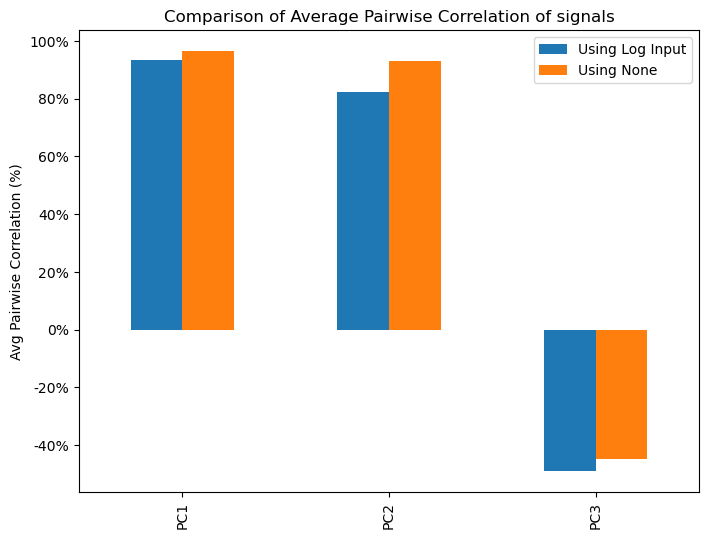

In [329]:
def plot_average_signal_pairwise_correlation(df_cross_correlation_comparison: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(figsize = (8,6))
    
    (df_cross_correlation_comparison.plot(
        xlabel = "",
        ax     = axes,
        kind   = "bar",
        ylabel = "Avg Pairwise Correlation (%)",
        title  = "Comparison of Average Pairwise Correlation of signals"))
    
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))

plot_average_signal_pairwise_correlation(df_cross_correlation_comparison)

In [319]:
def compare_avg_tsy_correlation(df_nom_pc: pd.DataFrame, df_log_pc: pd.DataFrame) -> pd.DataFrame: 

    df_nom_backtest = BackgroundHelperFuncs().get_backtest(df_nom_pc)
    df_log_backtest = BackgroundHelperFuncs().get_log_backtest(df_log_pc)
    
    df_out = pd.DataFrame()
    
    pcs = df_log_backtest.variable.drop_duplicates().to_list()
    for pc in pcs: 
    
        df_nom_corr = (df_nom_backtest.query(
            "variable == @pc")
            [["date", "security", "signal_bps"]].
            pivot(index = "date", columns = "security", values = "signal_bps").
            corr())
    
        df_log_corr = (df_log_backtest.query(
            "variable == @pc")
            [["date", "security", "signal_bps"]].
            pivot(index = "date", columns = "security", values = "signal_bps").
            corr())
    
        nom_avg = (df_nom_corr.reset_index().rename(
            columns = {"security": "security1"}).
            melt(id_vars = "security1").
            query("security != security1").
            query("value != 1").
            value.
            mean())
        
        log_avg = (df_log_corr.reset_index().rename(
            columns = {"security": "security1"}).
            melt(id_vars = "security1").
            query("security != security1").
            query("value != 1").
            value.
            mean())
    
        df_tmp = (pd.DataFrame(
            data = {
                "group": ["Using: Log", "Using: None"],
                "corr" : [log_avg, nom_avg]}).
            assign(pc = pc))
    
        df_out = pd.concat([df_tmp, df_out])

    return df_out

df_sec_avg_corr = compare_avg_tsy_correlation(df_nom_pc, df_log_pc)

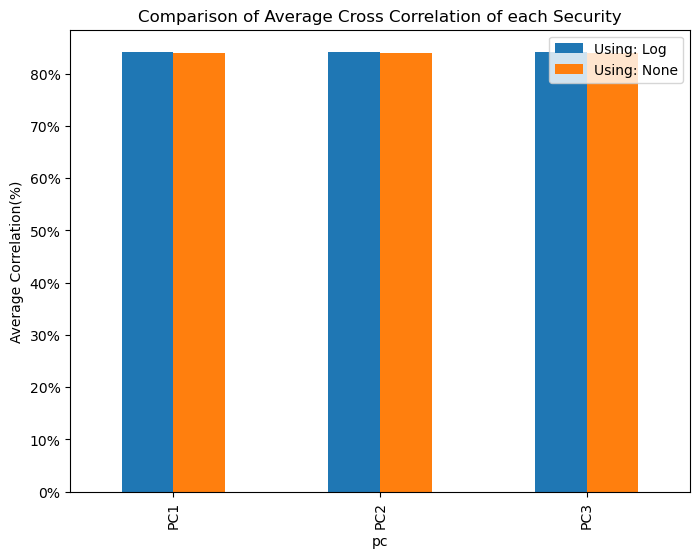

In [344]:
def plot_avg_tsy_correlatio(df_sec_avg_corr: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(figsize = (8,6))
    
    (df_sec_avg_corr.rename(
        columns = {"group": ""}).
        pivot(index = "pc", columns = "", values = "corr").
        plot(
            kind   = "bar",
            ax     = axes,
            title  = "Comparison of Average Cross Correlation of each Security",
            ylabel = "Average Correlation(%)"))
    
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))

plot_avg_tsy_correlatio(df_sec_avg_corr)

## Compare Returns

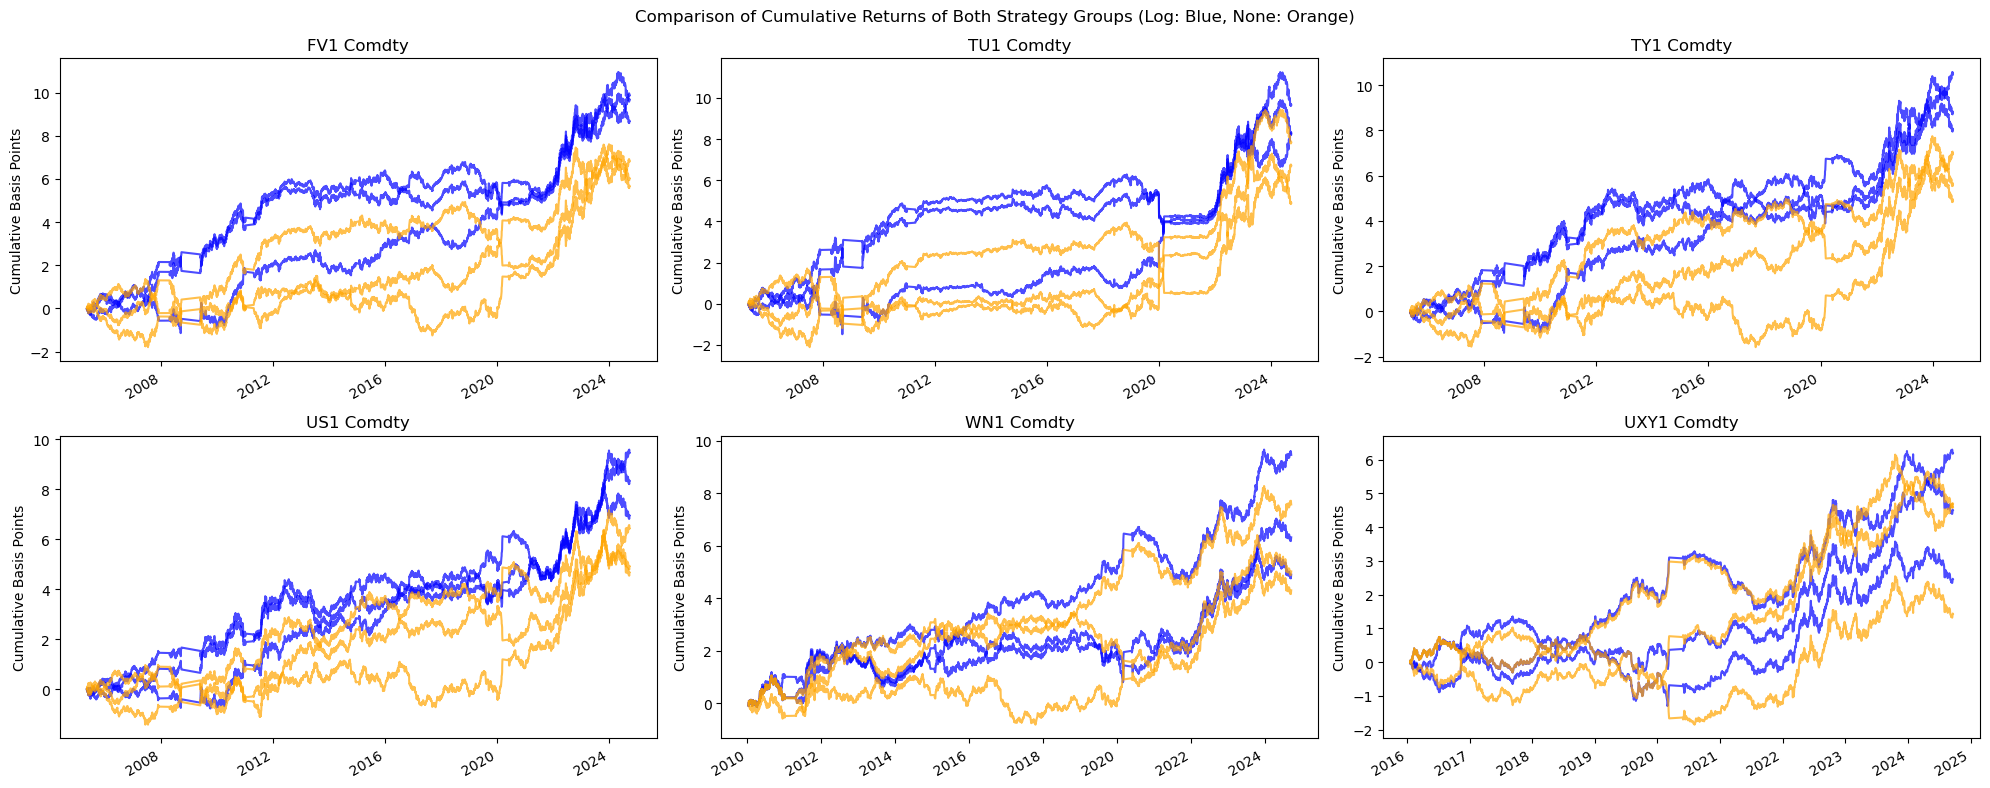

In [439]:
def plot_returns_comparison(df_combined: pd.DataFrame) -> plt.Figure: 

    group_dict = {
        "log_bps": "blue",
        "nom_bps": "orange"}
    
    futs = df_combined.security.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(futs) // 2, nrows = len(futs) // 3, figsize = (20,8))
    
    for fut, ax in zip(futs, axes.flatten()): 
    
        df_tmp = (df_combined.query(
            "security == @fut").
            drop(columns = ["security"]).
            rename(columns = {"variable": "pc"}).
            melt(id_vars = ["date", "pc"]).
            assign(tmp_name = lambda x: x.pc + " " + x.variable).
            drop(columns = ["variable", "pc"]).
            pivot(index = "date", columns = "tmp_name", values = "value").
            cumsum().
            reset_index().
            melt(id_vars = "date").
            assign(
                pc       = lambda x: x.tmp_name.str.split(" ").str[0],
                variable = lambda x: x.tmp_name.str.split(" ").str[-1]).
            drop(columns = ["tmp_name"]))
    
        for group in group_dict.keys():
    
            (df_tmp.query(
                "variable == @group").
                drop(columns = ["variable"]).
                pivot(index = "date", columns = "pc", values = "value").
                plot(
                    ax     = ax,
                    alpha  = 0.7,
                    color  = group_dict[group],
                    legend = False,
                    xlabel = "",
                    ylabel = "Cumulative Basis Points"))
    
        ax.set_title(fut)
    
    fig.suptitle("Comparison of Cumulative Returns of Both Strategy Groups (Log: Blue, None: Orange)")
    plt.tight_layout()

plot_returns_comparison(df_combined)

In [485]:
def get_strat_shapres(df_combined: pd.DataFrame) -> pd.DataFrame: 

    df_strat_sharpe = (df_combined.rename(
        columns = {"variable": "pc"}).
        melt(id_vars = ["date", "pc", "security"]).
        drop(columns = ["date"]).
        groupby(["pc", "security", "variable"]).
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        drop(columns = ["mean_rtn", "std_rtn"]).
        reset_index().
        assign(security = lambda x: x.security.str.split(" ").str[0]).
        rename(columns = {"variable": ""}).
        pivot(index = ["pc", "security"], columns = "", values = "sharpe").
        reset_index())

    return df_strat_sharpe

df_strat_sharpe = get_strat_shapres(df_combined)

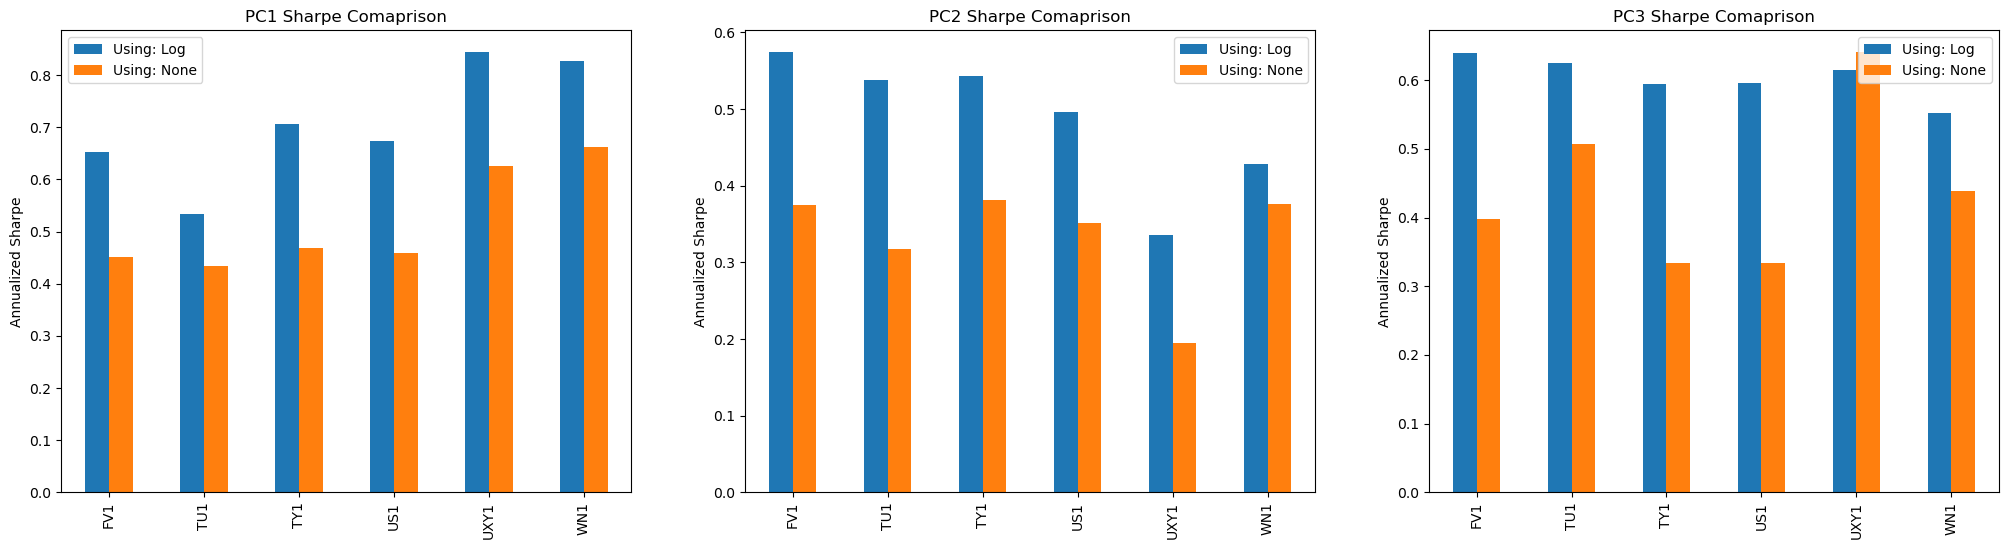

In [508]:
def plot_sharpe_comparison(df_strat_sharpe: pd.DataFrame) -> pd.DataFrame: 

    pcs         = df_strat_sharpe.pc.drop_duplicates().to_list()
    fig, axes   = plt.subplots(ncols = len(pcs), figsize = (25,6))
    col_renamer = {
        "log_bps": "Using: Log",
        "nom_bps": "Using: None"}
    
    
    for pc, ax in zip(pcs, axes.flatten()): 
    
        (df_strat_sharpe.query(
            "pc == @pc").
            drop(columns = ["pc"]).
            set_index("security").
            rename(columns = col_renamer).
            plot(
                ax     = ax,
                kind   = "bar",
                xlabel = "",
                ylabel = "Annualized Sharpe",
                title  = "{} Sharpe Comaprison".format(pc)))

plot_sharpe_comparison(df_strat_sharpe)

# ERC Portfolios

In [541]:
def combine_erc(df_log_backtest: pd.DataFrame, df_nom_backtest: pd.DataFrame) -> pd.DataFrame: 

    df_log_weight = BackgroundHelperFuncs().get_erc_weighting(df_log_backtest)
    df_log_erc    = BackgroundHelperFuncs().get_erc_rtn(df_log_weight)
    
    df_nom_weight = BackgroundHelperFuncs().get_erc_weighting(df_nom_backtest)
    df_nom_erc    = BackgroundHelperFuncs().get_erc_rtn(df_nom_weight)
    
    df_erc_left = (df_log_erc.reset_index().melt(
        id_vars = "date").
        rename(columns = {
            ""     : "pc",
            "value": "log_erc"}))
    
    df_nom_right = (df_nom_erc.reset_index().melt(
        id_vars = "date").
        rename(columns = {
            ""     : "pc",
            "value": "nom_erc"}))
    
    df_combined = (df_erc_left.merge(
        right = df_nom_right, how = "inner", on = ["date", "pc"]))

    return df_combined

df_erc_combined = combine_erc(df_log_backtest, df_nom_backtest)

In [561]:
def get_erc_sharpe(df_erc_combined: pd.DataFrame) -> pd.DataFrame: 

    df_erc_sharpe = (df_erc_combined.melt(
        id_vars = ["date", "pc"]).
        drop(columns = ["date"]).
        groupby(["pc", "variable"]).
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index()
        [["pc", "variable", "sharpe"]].
        rename(columns = {"variable": ""}).
        pivot(index = "pc", columns = "", values = "sharpe"))

    return df_erc_sharpe

df_erc_sharpe = get_erc_sharpe(df_erc_combined)

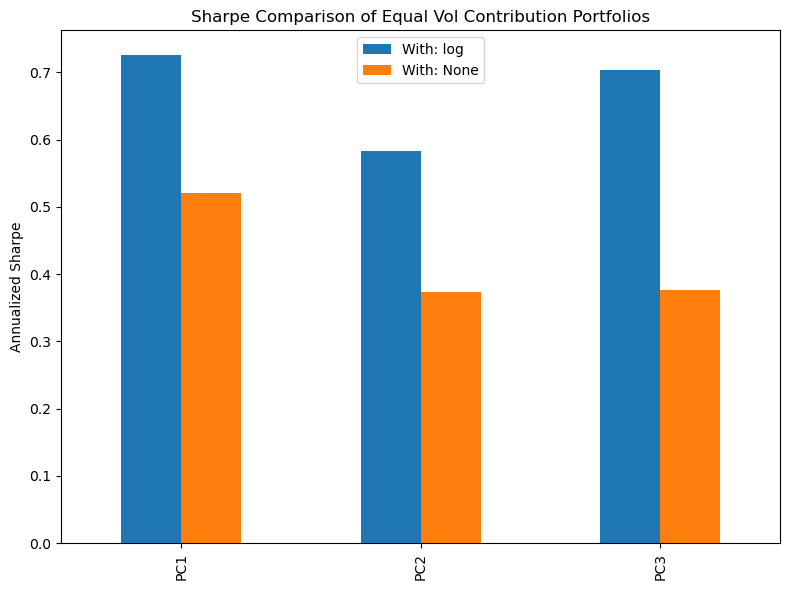

In [584]:
def plot_sharpe_comparison(df_erc_sharpe: pd.DataFrame) -> plt.Figure: 

    col_renamer = {
        "log_erc": "With: log",
        "nom_erc": "With: None"}
    
    (df_erc_sharpe.rename(
        columns = col_renamer).
        plot(
            kind    = "bar",
            ylabel  = "Annualized Sharpe",
            figsize = (8,6),
            xlabel  = "",
            title   = "Sharpe Comparison of Equal Vol Contribution Portfolios"))

    plt.tight_layout()

plot_sharpe_comparison(df_erc_sharpe)

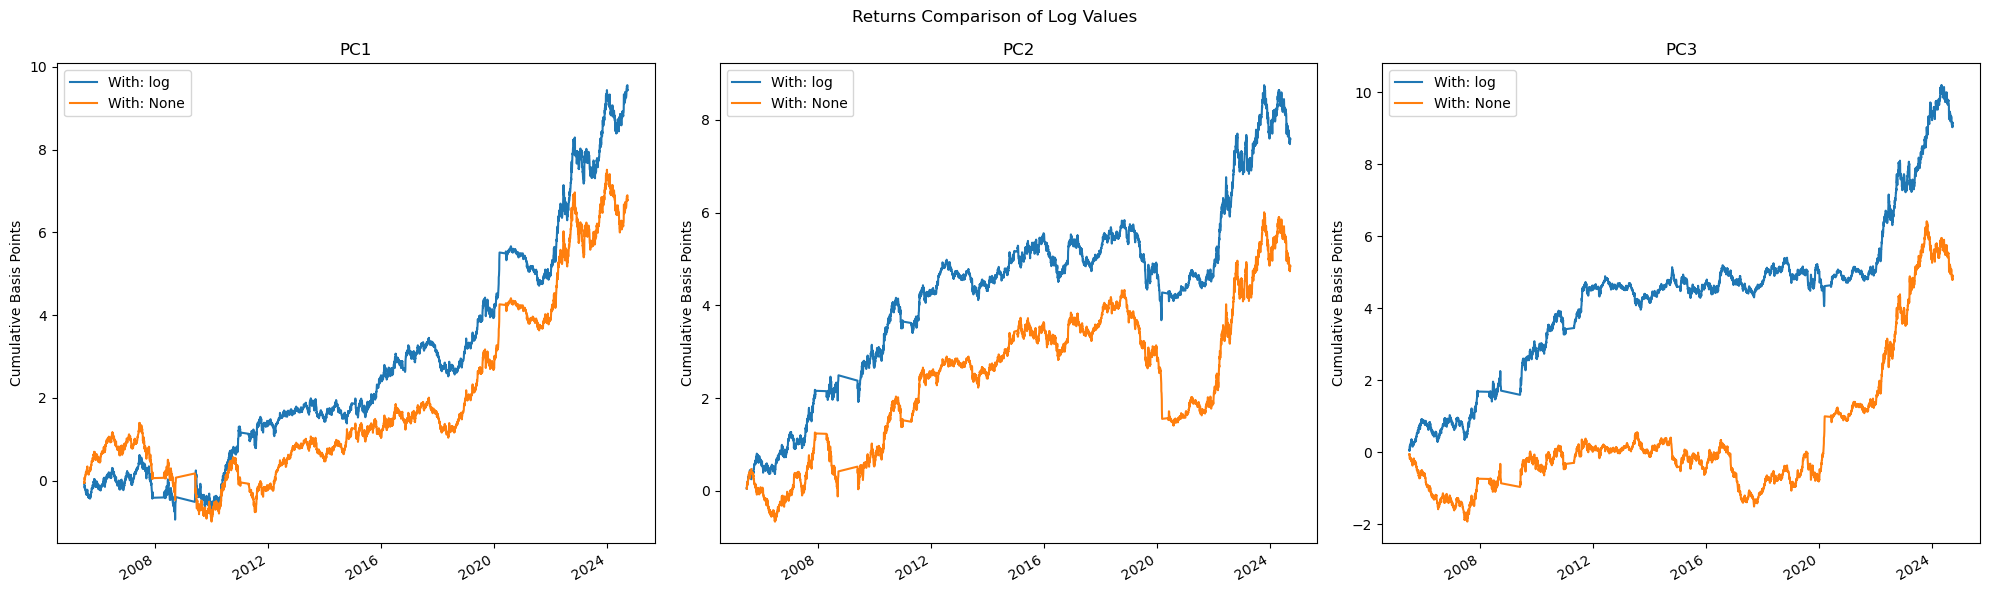

In [608]:
def plot_returns_comparison(df_erc_combined: pd.DataFrame) -> plt.Figure: 

    pcs       = df_erc_combined.pc.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(pcs), figsize = (20,6))
    
    col_renamer = {
        "log_erc": "With: log",
        "nom_erc": "With: None"}
    
    for pc, ax in zip(pcs, axes.flatten()): 
    
        (df_erc_combined.query(
            "pc == @pc").
            drop(columns = ["pc"]).
            rename(columns = col_renamer).
            set_index("date").
            cumsum().
            plot(
                ax = ax,
                ylabel = "Cumulative Basis Points",
                title  = pc,
                xlabel = ""))

    fig.suptitle("Returns Comparison of Log Values")
    plt.tight_layout()

plot_returns_comparison(df_erc_combined)